In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("salary_data.csv")
df.head()

,age,city,education,salary
0,58,Yogyakarta,PhD,16377000
1,48,Surabaya,PhD,19344000
2,34,Surabaya,PhD,18322000
3,27,Jakarta,Highschool,5768000
4,40,Medan,PhD,16545000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        500 non-null    int64 
 1   city       500 non-null    object
 2   education  500 non-null    object
 3   salary     500 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 15.8+ KB


In [4]:
df.describe()

,age,salary
count,500.00000,5.000000e+02
mean,40.91800,1.160849e+07
std,11.89244,4.487952e+06
min,20.00000,3.000000e+06
25%,31.00000,8.083000e+06
50%,42.50000,1.134550e+07
75%,51.00000,1.468900e+07
max,60.00000,2.288200e+07


In [5]:
df.isnull().sum()

age          0
city         0
education    0
salary       0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
#Cek nama kolom pendidikan
urutan = df['education'].value_counts()
urutan

education
Master        133
Highschool    132
Bachelor      128
PhD           107
Name: count, dtype: int64

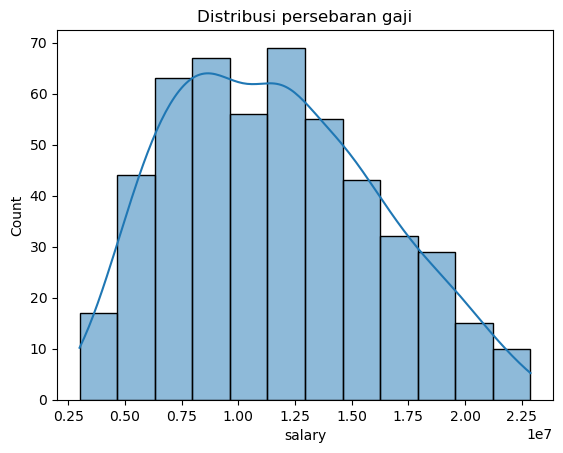

In [8]:
sns.histplot(df['salary'], kde=True)
plt.title("Distribusi persebaran gaji")
plt.show()

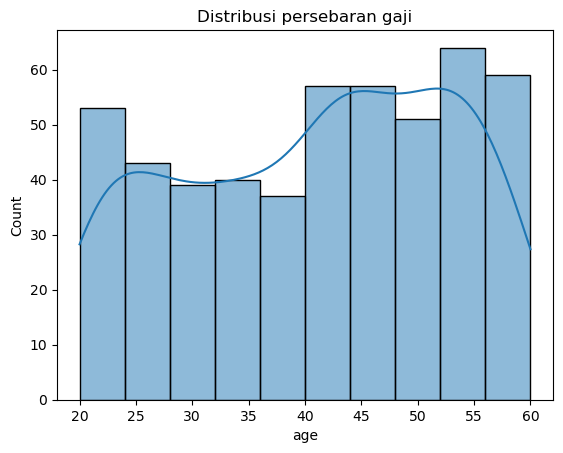

In [9]:
sns.histplot(df['age'], kde=True)
plt.title("Distribusi persebaran gaji")
plt.show()

In [10]:
skew_umur = df['age'].skew()
skew_gaji = df['salary'].skew()

In [11]:
print("Kemiringan Grafik umur : ", skew_umur)
print("Kemiringan Grafik Gaji : ", skew_gaji)

Kemiringan Grafik umur :  -0.20204380367825966
Kemiringan Grafik Gaji :  0.33723551220580267


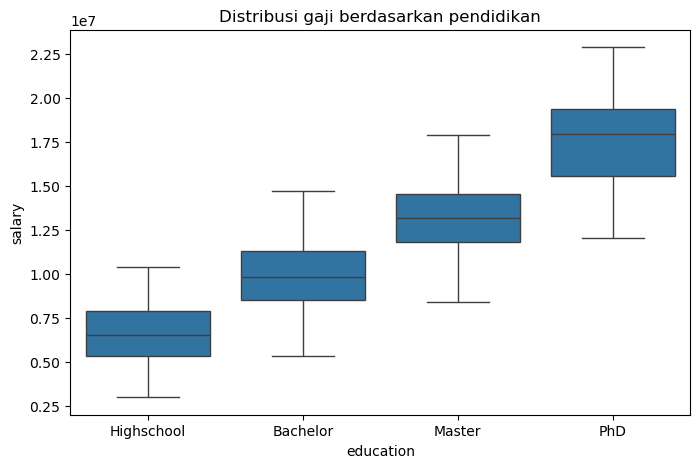

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(x='education', y='salary', data=df, order=['Highschool', 'Bachelor', 'Master', 'PhD'])
plt.title("Distribusi gaji berdasarkan pendidikan")
plt.show()

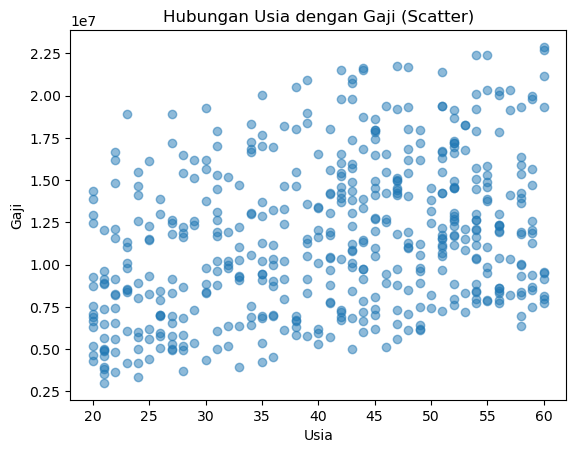

In [13]:
plt.scatter(df['age'], df['salary'], alpha=0.5)
plt.xlabel("Usia")
plt.ylabel("Gaji")
plt.title("Hubungan Usia dengan Gaji (Scatter)")
plt.show()

In [14]:
num_col = df.select_dtypes(include='int64')

In [15]:
num_col

,age,salary
0,58,16377000
1,48,19344000
2,34,18322000
3,27,5768000
4,40,16545000
...,...,...
495,49,9627000
496,36,9055000
497,39,18370000
498,44,9757000


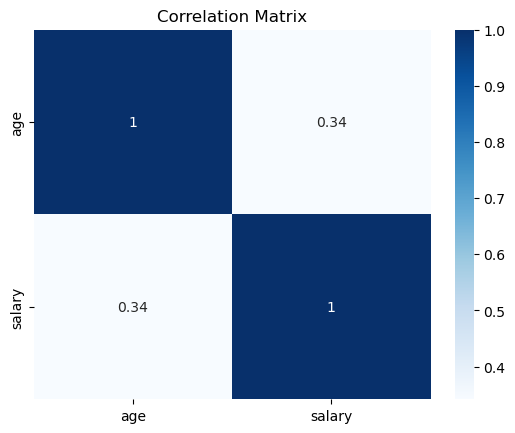

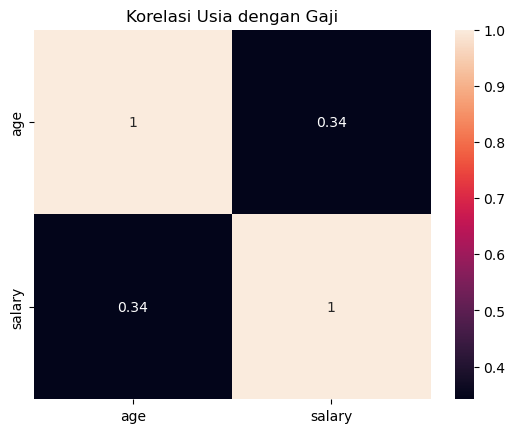

In [16]:
#Digunakan saat EDA
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Blues")
plt.title("Correlation Matrix")
plt.show()

#Digunakan saat Analisis lanjutan
num_corr = num_col.corr()
sns.heatmap(num_corr, annot=True)
plt.title("Korelasi Usia dengan Gaji")
plt.show()

In [17]:
df.nunique()

age           41
city           5
education      4
salary       487
dtype: int64

In [18]:
#Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [19]:
#Pisahkan X dan y (target)
X = df[["age", "city", "education"]]
y = df["salary"]

In [20]:
#Split data 80% train dan 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
#Pisahkan data sesuai kategori
cat_nominal = ['city']
cat_ordinal = ['education']
num_ratio = ['age']

In [22]:
#Encode dan Scale seluruh kolom untuk memprediksi
preprocessor = ColumnTransformer(
    transformers=[
        ('city', OneHotEncoder(drop="first"), cat_nominal),
        ('education', OrdinalEncoder(categories=[["Highschool", "Bachelor", "Master", "PhD"]]), cat_ordinal),
        ('age', StandardScaler(), num_ratio)
    ]
)

In [23]:
#Buat pipeline modelnya (dengan hyperparameter tuning)
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [24]:
#Memunculkan metrik evaluasi
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model: XGBoost")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

Model: XGBoost
MAE:  493649.56
RMSE: 606507.71
R²:   0.984


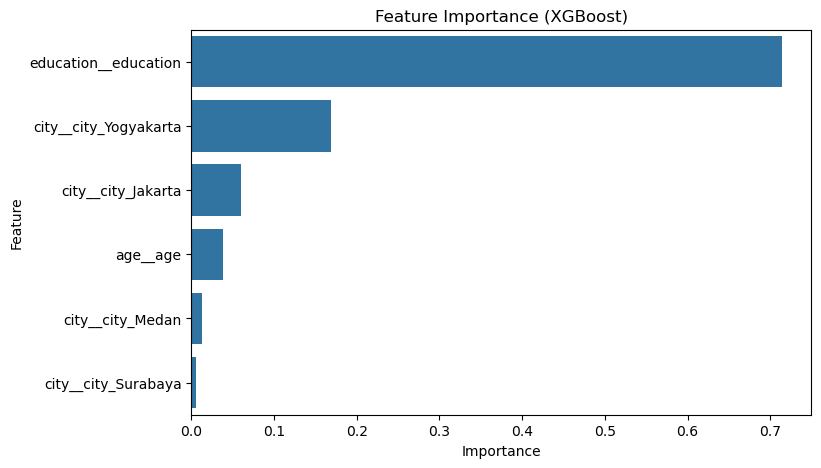

In [25]:
# Ambil nama feature setelah transformasi
feature_names = pipe.named_steps["preprocessor"].get_feature_names_out()
importances = pipe.named_steps["model"].feature_importances_

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Visualisasi
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=fi_df)
plt.title("Feature Importance (XGBoost)")
plt.show()

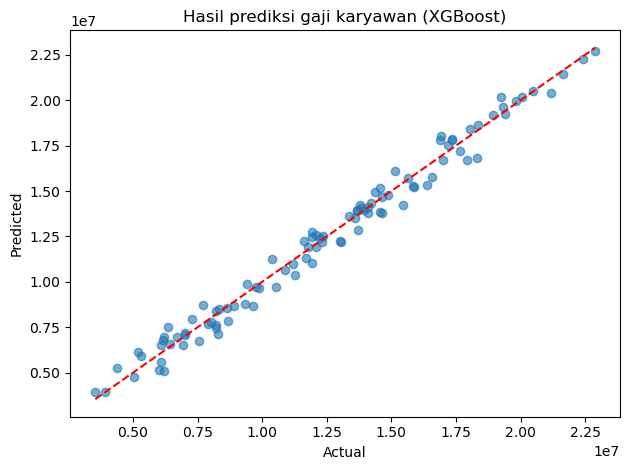

In [26]:
#Visualisasi hasil prediksi dengan scatter dengan data uji (test) garis linier
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.title("Hasil prediksi gaji karyawan (XGBoost)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()


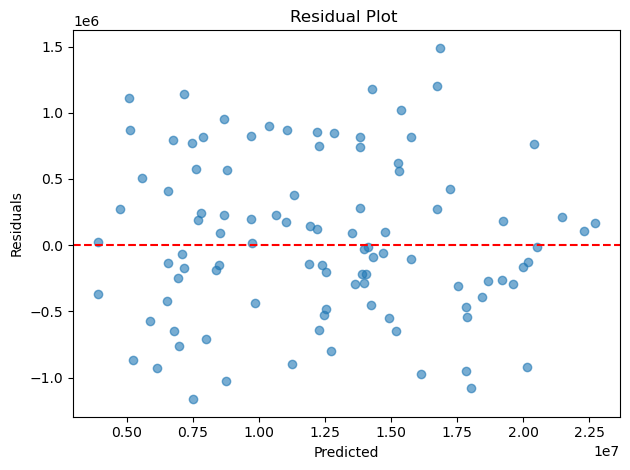

In [27]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')  # garis nol
plt.title("Residual Plot ")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()


In [28]:
df[df['salary'].duplicated(keep=False)]

,age,city,education,salary
23,31,Medan,Highschool,5023000
25,44,Jakarta,Highschool,9131000
57,37,Medan,Bachelor,9131000
75,60,Medan,PhD,19329000
87,36,Jakarta,Bachelor,11182000
112,56,Jakarta,Master,17864000
136,55,Medan,Bachelor,11062000
143,25,Bandung,Master,11435000
148,30,Bandung,Bachelor,8328000
150,44,Surabaya,Bachelor,11435000
